# **EDA Sơ bộ (trước khi Pre-processing)**

### **Import Libraries**

In [95]:
import re
import math
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

### **Load data**

In [96]:
df = pd.read_csv('../Data/data_crawl_balanced.csv')

In [97]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

### **Kiểm tra tổng quan (Overview)**

#### Xem cấu trúc

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31000 entries, 0 to 30999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           31000 non-null  object
 1   source         31000 non-null  object
 2   title          31000 non-null  object
 3   content        31000 non-null  object
 4   category_lvl1  31000 non-null  object
 5   url            31000 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [99]:
df.columns

Index(['date', 'source', 'title', 'content', 'category_lvl1', 'url'], dtype='object')

In [100]:
df.rename(columns={'category_lvl1': 'category'}, inplace=True)

In [101]:
df.head(5)

,date,source,title,content,category,url
0,16/8/2024,VnExpress,Những lỗi cần tránh khi thiết kế giếng trời,Giếng trời là không gian thông suốt từ tầng tr...,Bất động sản,https://vnexpress.net/nhung-loi-can-tranh-khi-...
1,19/12/2023,VnExpress,Căn hộ thông tầng 240 m2 hướng sông Hồng với n...,Căn hộ thông tầng (duplex) có quy mô 2 tầng vớ...,Bất động sản,https://vnexpress.net/can-ho-thong-tang-240-m2...
2,7/11/2024,VnExpress,'Không được kiểm tra hiện trạng công trình khi...,"Nội dung được ông Nguyễn Toàn Thắng, Giám đốc ...",Bất động sản,https://vnexpress.net/khong-duoc-kiem-tra-hien...
3,11/6/2024,VnExpress,Hà Nội đề xuất xây mới 9 khu nhà ở xã hội,Thông tin này được Sở Xây dựng Hà Nội nêu tron...,Bất động sản,https://vnexpress.net/ha-noi-de-xuat-xay-moi-9...
4,29/1/2025,VnExpress,Biệt thự 700 m2 đưa thiên nhiên vào trung tâm,"Căn biệt thự có quy mô hai tầng, được xây dựng...",Bất động sản,https://vnexpress.net/biet-thu-700-m2-dua-thie...


In [102]:
df.tail(5)

,date,source,title,content,category,url
30995,2025-09-15,VnExpress,Tác dụng của việc rửa lạc trước khi rang,Lạc chứa nhiều protein và lipid nên khi rang c...,Đời sống,https://vnexpress.net/doi-song-cooking-rua-lac...
30996,2025-10-24,VnExpress,Thế hệ sinh tồn nhờ đồ đông lạnh,"Taylor, 25 tuổi, nhân viên bán hàng tại Austin...",Đời sống,https://vnexpress.net/the-he-sinh-ton-nho-do-d...
30997,2025-11-13,VnExpress,Tranh cãi nhà hàng không tiếp khách đi một mình,"Tấm biển của nhà hàng, được một thực khách chụ...",Đời sống,https://vnexpress.net/tranh-cai-nha-hang-khong...
30998,22/8/2025,VnExpress,Bỏ phố về làm 'CEO nông thôn',"Tại làng Dư Thôn, tỉnh Chiết Giang, anh Zhuo L...",Đời sống,https://vnexpress.net/bo-pho-ve-lam-ceo-nong-t...
30999,4/4/2025,VnExpress,PNJ lan tỏa thông điệp yêu thương qua bộ sưu t...,"Từ hình ảnh ""thả tim"", hành động dùng hai ngón...",Đời sống,https://vnexpress.net/pnj-lan-toa-thong-diep-y...


#### Kiểm tra Missing Values

In [103]:
df.isna().sum()

date        0
source      0
title       0
content     0
category    0
url         0
dtype: int64

#### Kiểm tra duplicate

In [104]:
df.duplicated().sum()

np.int64(0)

Xóa Rác Tuyệt đối

In [105]:
df[['title', 'content']].duplicated().sum()

np.int64(0)

* Không có bài báo nào là bản sao lưu của nhau

Loại bỏ Bản sao

In [106]:
df['content'].duplicated().sum()

np.int64(0)

+ Không có bài báo nào có nội dung viết như nhau là sao lưu nội dung của nhau

Trùng Tiêu đề (Phân biệt)

In [107]:
df['title'].duplicated().sum()

np.int64(2778)

* GIỮ LẠI. Đây là trường hợp nội dung riêng biệt, chỉ tiêu đề chung chung hoặc định kỳ.

- Không có trùng lặp bất kì bài báo nào

#### Kiểm tra nhiễu

In [108]:
def check_noise_health(df, column_name='content'):
    print("=== BÁO CÁO TÌNH TRẠNG NHIỄU (DATA HEALTH CHECK) ===")
    total = len(df)
    
    html_pattern = r'<[^>]*>'          
    url_pattern = r'http[s]?://\S+'   
    js_pattern = r'function\s*\(|var\s+\w+\s*=' 
    email_pattern = r'\S*@\S*\.\S*'   
    
    html_count = df[column_name].str.contains(html_pattern, regex=True).sum()
    url_count = df[column_name].str.contains(url_pattern, regex=True).sum()
    js_count = df[column_name].str.contains(js_pattern, regex=True).sum()
    email_count = df[column_name].str.contains(email_pattern, regex=True).sum()
    
    print(f"- Tổng số bài viết: {total}")
    print(f"- Chứa thẻ HTML: {html_count} ({html_count/total*100:.2f}%)")
    print(f"- Chứa URL/Link: {url_count} ({url_count/total*100:.2f}%)")
    print(f"- Chứa Email:    {email_count} ({email_count/total*100:.2f}%)")
    print(f"- Nghi vấn Code: {js_count} ({js_count/total*100:.2f}%)")
    
    if (html_count + url_count) > 0:
        print("\nCần chạy lại regex cleaning kỹ hơn!")
    else:
        print("\nDữ liệu sạch sẽ.")

In [109]:
check_noise_health(df, 'content')

=== BÁO CÁO TÌNH TRẠNG NHIỄU (DATA HEALTH CHECK) ===
- Tổng số bài viết: 31000
- Chứa thẻ HTML: 2 (0.01%)
- Chứa URL/Link: 63 (0.20%)
- Chứa Email:    47 (0.15%)
- Nghi vấn Code: 1 (0.00%)

Cần chạy lại regex cleaning kỹ hơn!


#### Xử lý thời gian

In [110]:
df['date'] = df['date'].astype(str).str.strip().str.replace(r'[^\d\-\/]+', '', regex=True)

In [111]:
df['date_clean'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

In [112]:
df_fail_date = df[df['date_clean'].isna()]

In [113]:
df_fail_date['date_clean'] = pd.to_datetime(df_fail_date['date'], format="%Y-%m-%d")

C:\Users\Admin\AppData\Local\Temp\ipykernel_24948\3235427275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail_date['date_clean'] = pd.to_datetime(df_fail_date['date'], format="%Y-%m-%d")


In [114]:
df.loc[df['date_clean'].isna(), 'date_clean'] = df_fail_date['date_clean'].values

In [115]:
df['date_clean'].head(5)

0   2024-08-16
1   2023-12-19
2   2024-11-07
3   2024-06-11
4   2025-01-29
Name: date_clean, dtype: datetime64[ns]

In [116]:
df['date_clean'].isna().sum()

np.int64(0)

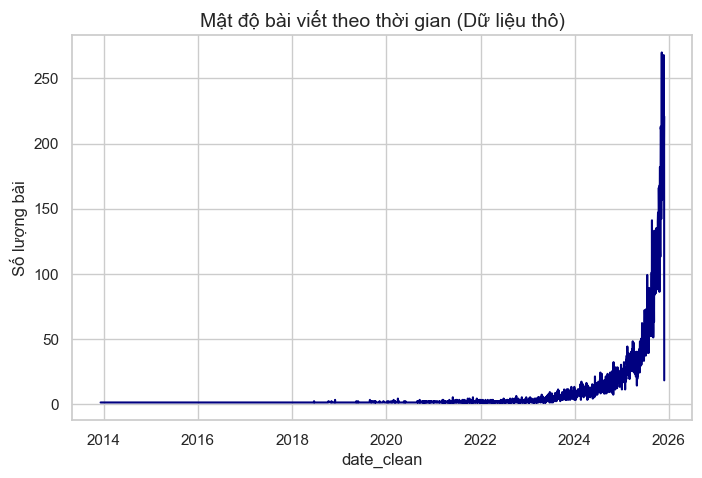

In [117]:
daily_counts = df.groupby(df['date_clean'].dt.date).size()

plt.figure(figsize=(8, 5))
daily_counts.plot(kind='line', color='navy')
plt.title('Mật độ bài viết theo thời gian (Dữ liệu thô)', fontsize=14)
plt.ylabel('Số lượng bài')
plt.show()

- Dữ liệu được thu thập liên tục từ năm 2014 đến gần năm 2025 không có khoảng trống (missing dates), đảm bảo khả năng phát hiện xu hướng liên tục. 
- Nhưng số lượng bài báo ở khoảng năm 2024 đến gần năm 2026 thì sẽ nhiều hơn. Cho biết đa số các bài báo trong dataset này thuộc những bài báo của những khoảng 2024 - 2026

#### Kiểm tra độ cân bằng nhãn

C:\Users\Admin\AppData\Local\Temp\ipykernel_24948\3811829879.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')


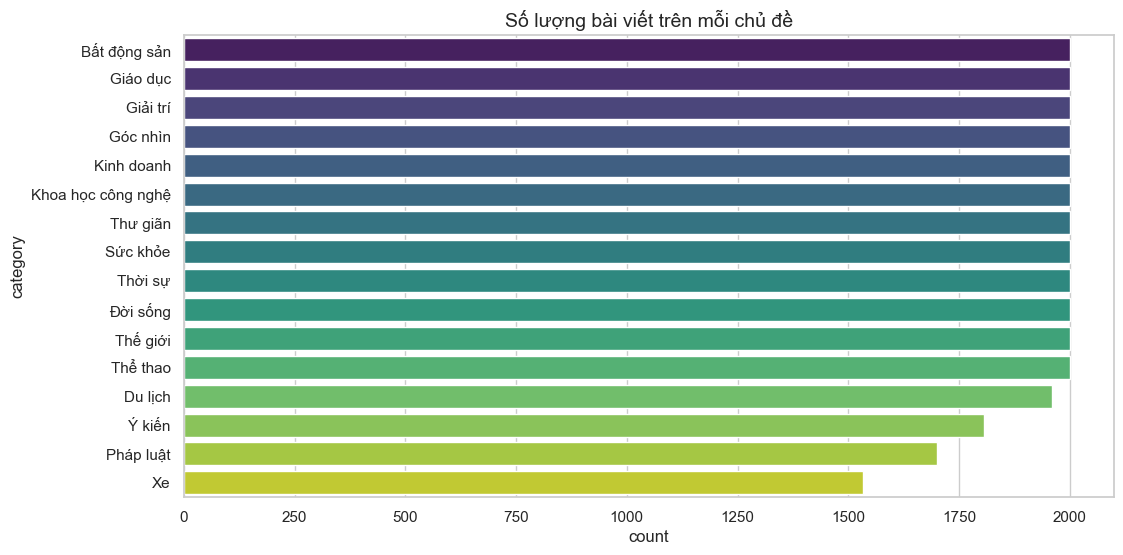

In [118]:
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')
plt.title('Số lượng bài viết trên mỗi chủ đề', fontsize=14)
plt.show()

- Với 16 chủ đề có số lượng mẫu đồng đều (> 1500 mẫu/lớp), bộ dữ liệu đạt trạng thái cân bằng lý tưởng, giúp giảm thiểu rủi ro bias cho mô hình Classification.
- Với số lượng sample ở category xe và pháp luật đều dưới 1750 nhưng so số lượng với các category khác thì không chênh lệch nhiều

#### Kiểm tra độ dài thô & Lọc rác

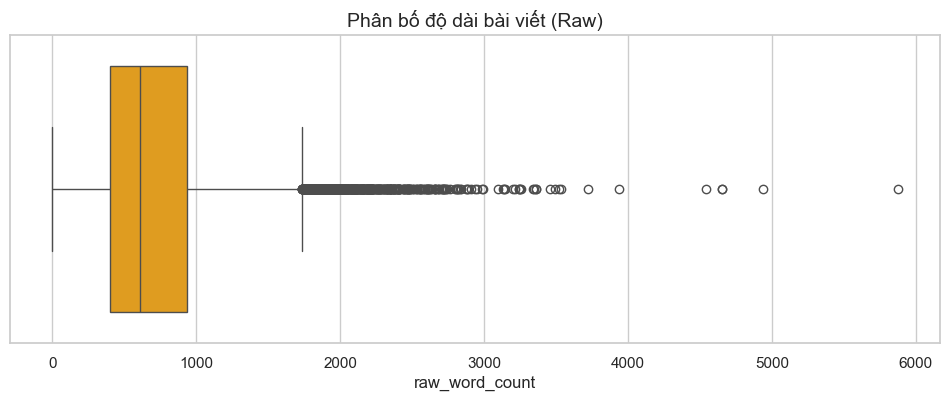

In [119]:
df['raw_word_count'] = df['content'].apply(lambda x: len(str(x).split()))

# Vẽ Boxplot để nhìn rõ outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=df['raw_word_count'], color='orange')
plt.title('Phân bố độ dài bài viết (Raw)', fontsize=14)
plt.show()

- Theo quan sát phát hiện có các outlier kéo dài từ khoảng 1.800 đến 6.000 từ
- Quyết định xem xét loại bỏ các bài báo có số lượng từ < 50 và > 3000 có ảnh hưởng đến mô hình hoặc không có thông tin quan trong, không phải là bài báo

In [120]:
print("--- Các bài quá dài (> 3000 từ) ---")
long_articles = df[df['raw_word_count'] >= 3000]
print(f"Số lượng bài > 3000 từ: {len(long_articles)}")
if len(long_articles) > 0:
    print(long_articles[['content']].iloc[0].values)

print("\n--- Các bài quá ngắn (<= 50 từ) ---")
short_articles = df[df['raw_word_count'] <= 50]
print(f"Số lượng bài <= 50 từ: {len(short_articles)}")

if len(short_articles) > 0:
    print(short_articles[['content']].iloc[0].values)

--- Các bài quá dài (> 3000 từ) ---
Số lượng bài > 3000 từ: 25
['Cách đây ba năm, Bùi Huyền Chi, sống tại Pháp đã mua vé máy bay và thuê xe van ở Georgia, dự định cắm trại hai tuần tại đây nhưng kế hoạch bị hoãn do dịch Covid - 19. Đến 9/5 vừa qua, Chi mới đặt chân đến Georgia, đánh dấu chuyến du lịch ngoài châu Âu đầu tiên sau ba năm. Cộng hòa Georgia là một quốc gia Tây Á, nằm gần ranh giới giữa châu Á và châu Âu, giáp Nga ở phía bắc và Thổ Nhĩ Kỳ, Armenia, Azerbaijan ở phía nam. Georgia từng nằm dưới sự cai trị của các nước châu Âu và châu Á khác nhau trong nhiều thế kỷ. Do vậy, quốc gia này mang bản sắc của nhiều nền văn hóa. Cách đây ba năm, Bùi Huyền Chi, sống tại Pháp đã mua vé máy bay và thuê xe van ở Georgia, dự định cắm trại hai tuần tại đây nhưng kế hoạch bị hoãn do dịch Covid - 19. Đến 9/5 vừa qua, Chi mới đặt chân đến Georgia, đánh dấu chuyến du lịch ngoài châu Âu đầu tiên sau ba năm. Cộng hòa Georgia là một quốc gia Tây Á, nằm gần ranh giới giữa châu Á và châu Âu, giáp Ng

- Sau khi xem thông tin nội dung của một bài báo có độ dài từ <=50 và >=3000 thì:
+ Quyết định giữ có bài báo có số lượng kí tự >=3000 Vì nó là bài báo có thể chứa các thông tin quan trọng cho mô hình. Nếu quá dài để đưa vào mô hình thì sẽ xử lý ở bước feature engineering.
+ Quyết định xoá các bài có số lượng từ  <= 50 vì các bài đó không mang thông tin bổ ích gì mà còn kèm theo các kí từ nhiễu.

In [121]:
# Quyết định lọc (Bỏ bài dưới 50 từ và trên 3000 từ)
df = df[(df['raw_word_count'] >= 50) & (df['raw_word_count'] <= 3000)].copy()
print(f"Số lượng mẫu còn lại sau khi lọc rác: {len(df)}")

Số lượng mẫu còn lại sau khi lọc rác: 30122


### **Lưu lại dataset đã được lọc các outlier và xử lí dữ liệu thô**

In [122]:
df.to_csv('../Data/vietnamese_news_cleaned_raw.csv', index=False)

# **EDA chuyên sâu (Sau Pre-processing)**

### **Load cleaned data**

In [123]:
df_clean = pd.read_csv("../Data/vietnamese_news_preprocessed.csv")

In [124]:
df_clean.head(5)

,date,source,title,content,category,url,date_clean,raw_word_count,clean_content,clean_title,token_count
0,16/8/2024,VnExpress,Những lỗi cần tránh khi thiết kế giếng trời,Giếng trời là không gian thông suốt từ tầng tr...,Bất động sản,https://vnexpress.net/nhung-loi-can-tranh-khi-...,2024-08-16,731,giếng trời không_gian thông_suốt tầng mái phươ...,lỗi thiết_kế giếng trời,277
1,19/12/2023,VnExpress,Căn hộ thông tầng 240 m2 hướng sông Hồng với n...,Căn hộ thông tầng (duplex) có quy mô 2 tầng vớ...,Bất động sản,https://vnexpress.net/can-ho-thong-tang-240-m2...,2023-12-19,858,căn_hộ thông tầng duplex quy_mô tầng tổng diện...,căn_hộ thông tầng m hướng sông hồng nội_thất t...,398
2,7/11/2024,VnExpress,'Không được kiểm tra hiện trạng công trình khi...,"Nội dung được ông Nguyễn Toàn Thắng, Giám đốc ...",Bất động sản,https://vnexpress.net/khong-duoc-kiem-tra-hien...,2024-11-07,481,nội_dung nguyễn_toàn_thắng giám_đốc sở tài_ngu...,kiểm_tra hiện_trạng công_trình đăng_ký biến_độ...,188
3,11/6/2024,VnExpress,Hà Nội đề xuất xây mới 9 khu nhà ở xã hội,Thông tin này được Sở Xây dựng Hà Nội nêu tron...,Bất động sản,https://vnexpress.net/ha-noi-de-xuat-xay-moi-9...,2024-06-11,538,thông_tin sở xây_dựng hà_nội nêu báo_cáo tình_...,hà_nội đề_xuất xây khu xã_hội,176
4,29/1/2025,VnExpress,Biệt thự 700 m2 đưa thiên nhiên vào trung tâm,"Căn biệt thự có quy mô hai tầng, được xây dựng...",Bất động sản,https://vnexpress.net/biet-thu-700-m2-dua-thie...,2025-01-29,732,biệt_thự quy_mô hai tầng xây_dựng khu đất rộng...,biệt thự m thiên_nhiên trung_tâm,345


### **Xác nhận Hiệu quả pre-processing**

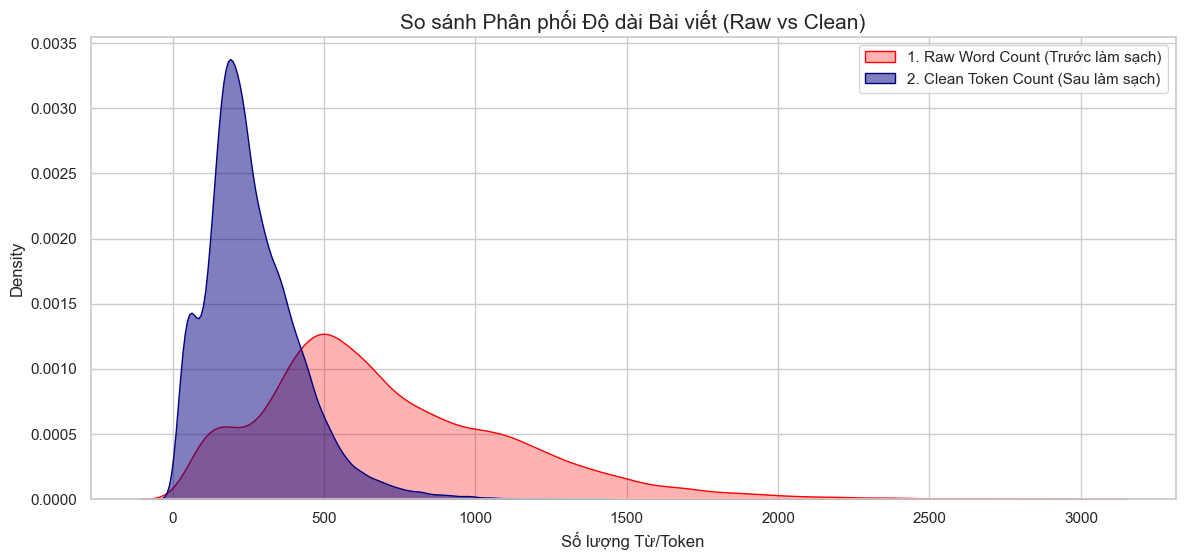

Token trung bình (Raw): 709.92
Token trung bình (Clean): 265.86


In [125]:
df_clean['token_count'] = df_clean['clean_content'].apply(lambda x: len(str(x).split()))


df_filtered = df_clean[df_clean['token_count'] >= 5].copy()

plt.figure(figsize=(14, 6))
sns.kdeplot(df_filtered['raw_word_count'], label='1. Raw Word Count (Trước làm sạch)', color='red', fill=True, alpha=0.3)
sns.kdeplot(df_filtered['token_count'], label='2. Clean Token Count (Sau làm sạch)', color='navy', fill=True, alpha=0.5)

plt.title('So sánh Phân phối Độ dài Bài viết (Raw vs Clean)', fontsize=15)
plt.xlabel('Số lượng Từ/Token')
plt.legend()
plt.show()

print(f"Token trung bình (Raw): {df_filtered['raw_word_count'].mean():.2f}")
print(f"Token trung bình (Clean): {df_filtered['token_count'].mean():.2f}")

- Trước làm sạch (Raw): Dữ liệu phân tán rộng, đỉnh thấp, chứng tỏ có nhiều tạp âm (noise) và nhiều bài viết có độ dài khác nhau.

- Sau làm sạch (Clean): Dữ liệu cực kỳ tập trung (đỉnh cao), chứng tỏ quá trình loại bỏ Stopword đã thành công trong việc loại bỏ nhiễu và tập trung hầu hết các bài viết vào một dải độ dài tối ưu cho mô hình học máy.Giá trị phổ biến nhất (mode) của độ dài bài viết sạch đã chuyển dịch về khoảng 200-300 token.

- Số token của Clean so với Raw giảm đáng kể (265.86 < 709.92). Cho thấy quá trình pre-processing đã giảm số token đáng kể để thuận tiện hơn khi đưa vào mô hình huấn luyện và giúp mô hình học hiệu quả hơn.


### **Phân tích Tần suất từ (Word Frequency)**

In [138]:
def analyze_word_frequency(df, column_name, title, top_n=20):
    all_text = " ".join(df[column_name].astype(str).tolist())
    
    words = all_text.split()
    
    word_counts = Counter(words)
    common_words = word_counts.most_common(top_n)
    
    df_freq = pd.DataFrame(common_words, columns=['Word', 'Count'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_freq, x='Count', y='Word', hue='Word', palette='viridis')
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Tần suất xuất hiện')
    plt.ylabel('Từ')
    plt.show()

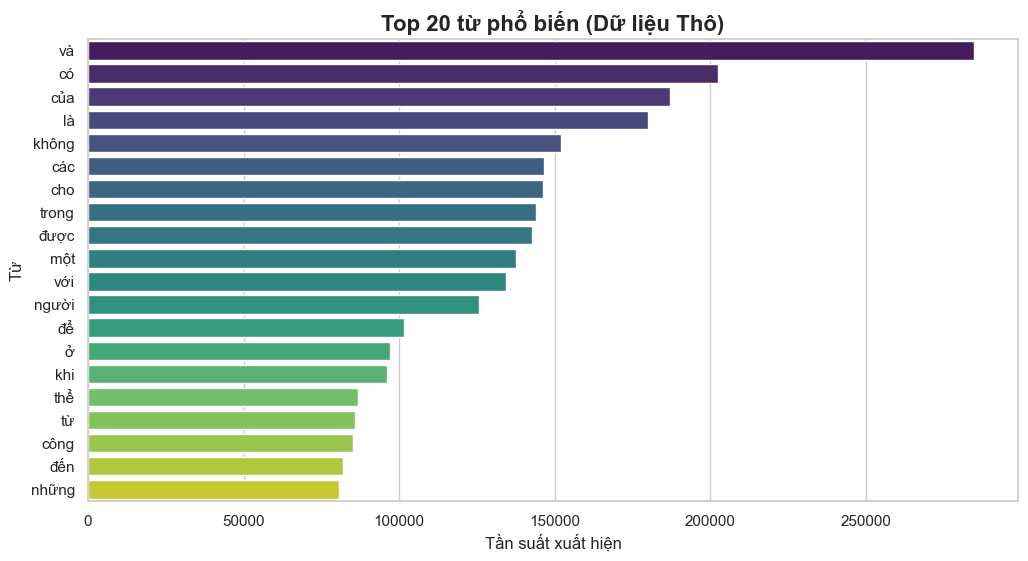

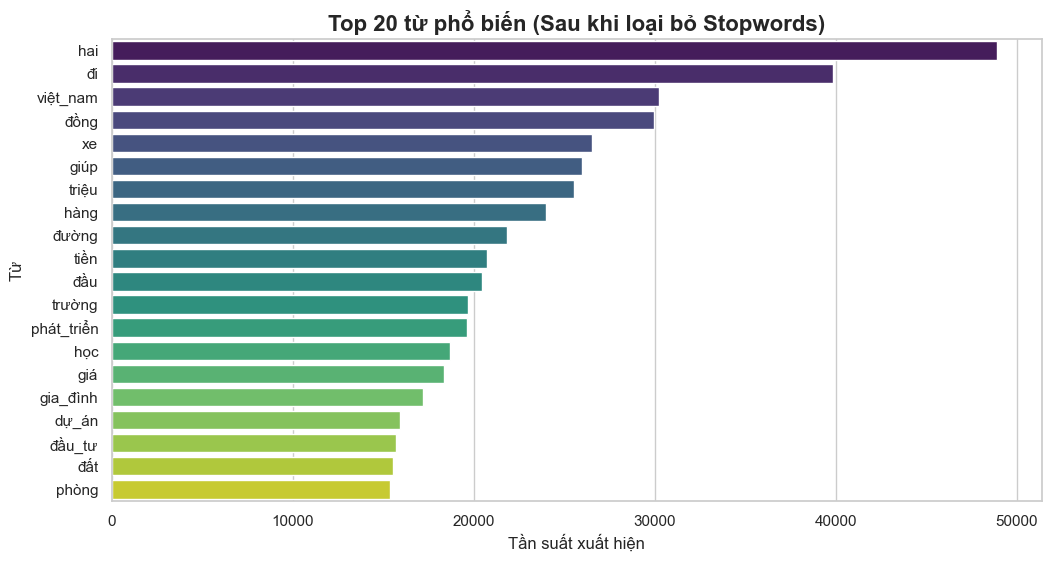

In [139]:
analyze_word_frequency(df_clean, 'content', 'Top 20 từ phổ biến (Dữ liệu Thô)')
analyze_word_frequency(df_clean, 'clean_content', 'Top 20 từ phổ biến (Sau khi loại bỏ Stopwords)')

### **Phân bố độ dài**

C:\Users\Admin\AppData\Local\Temp\ipykernel_24948\2759977349.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


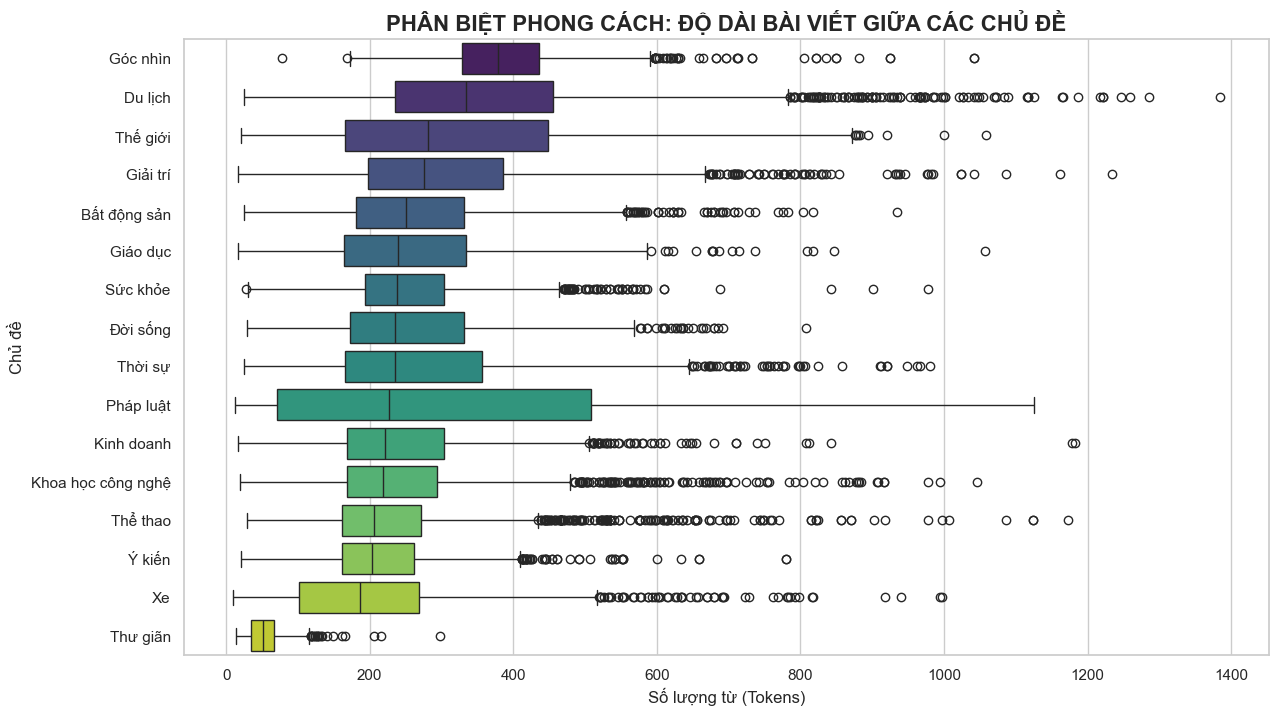

In [129]:
df_filtered['word_count'] = df_filtered['clean_content'].apply(lambda x: len(str(x).split()))

sorted_idx = df_filtered.groupby('category')['word_count'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_filtered,
    x='word_count',
    y='category',
    order=sorted_idx, 
    palette='viridis'
)

plt.title('PHÂN BIỆT PHONG CÁCH: ĐỘ DÀI BÀI VIẾT GIỮA CÁC CHỦ ĐỀ', fontsize=16, weight='bold')
plt.xlabel('Số lượng từ (Tokens)')
plt.ylabel('Chủ đề')
plt.show()

Biểu đồ Boxplot minh họa phân phối số lượng từ (Tokens) sau khi làm sạch của 16 chủ đề. Ta nhận thấy một sự phân tầng rõ rệt về độ dài văn bản, phản ánh đúng đặc thù biên tập của từng loại hình tin tức:
- Nhóm "Long-form" (Chuyên sâu): Đứng đầu là chuyên mục "Góc nhìn" (trên cùng). Với trung vị (median) cao nhất và dải phân tán rộng, các bài viết này thường là bài xã luận, phân tích đa chiều, đòi hỏi dung lượng từ lớn để triển khai luận điểm.

- N- hóm "Short-form" (Tin vắn): Ngược lại hoàn toàn, chuyên mục "Thư giãn" (dưới cùng) có độ dài cực ngắn (phần lớn < 100 tokens). Đây thường là các mẩu chuyện cười, đố vui hoặc tin ảnh, phục vụ nhu cầu giải trí nhanh.

- Nhóm biến thiên mạnh: Đáng chú ý là mục "Pháp luật" (màu xanh ngọc). Mặc dù độ dài trung bình ở mức phổ thông (~250 tokens), nhưng "đuôi" dữ liệu (outliers) kéo rất dài sang phải (lên tới 1200+ tokens). Điều này cho thấy chủ đề này pha trộn giữa các tin an ninh trật tự ngắn và các bài phóng sự điều tra/cáo trạng rất dài.

Biểu đồ khẳng định rằng Độ dài bài viết (Article Length) không phải là một biến số ngẫu nhiên mà là một đặc trưng mang tính quy luật.

- Tin "Thế giới" và "Du lịch" thường dài hơn tin "Giải trí" hay "Xe" do tính chất mô tả chi tiết địa danh hoặc bối cảnh chính trị.

- Sự ổn định (độ dài hộp ngắn) ở các mục như "Sức khỏe" hay "Xe" cho thấy cấu trúc bài viết ở các mục này khá chuẩn hóa

--> Nếu mô hình gặp một văn bản cực ngắn, xác suất thuộc về lớp 'Thư giãn' sẽ tăng lên đáng kể. Ngược lại, một văn bản rất dài với nhiều từ ngữ phân tích sẽ là tín hiệu mạnh cho lớp 'Góc nhìn' hoặc 'Pháp luật', giúp mô hình phân tách chúng khỏi các lớp tin tức thông thường.

### **Phân tích N-grams**

* Phân tích này giúp tìm ra các cụm từ (Bigrams, Trigrams) đặc trưng giúp phân loại 16 chủ đề.

In [130]:
def get_top_n_grams(text_series, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=10000)
    
    X = vectorizer.fit_transform(text_series.astype(str))
    
    sum_words = X.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

all_categories = df_filtered['category'].unique()
all_categories_top_ngrams = {}

print(f"Bắt đầu phân tích Top Bigrams (n=2) cho {len(all_categories)} Category...")
for category in all_categories:
    text_category = df_filtered[df_filtered['category'] == category]['clean_content']
    if len(text_category) > 10: 
        top_bigrams = get_top_n_grams(text_category, n=2, top_k=10)
        all_categories_top_ngrams[category] = top_bigrams
        print(f"-> Hoàn thành '{category}'")
    else:
        print(f"--- Bỏ qua Category '{category}' do quá ít dữ liệu. ---")
print("\n" + "="*50)
print("KẾT QUẢ TỔNG HỢP TOP BIGRAMS (N=2)")
print("="*50)

for category, bigrams in all_categories_top_ngrams.items():
    print(f"\n### {category} ###")
    for word, freq in bigrams:
        print(f"- {word}: {freq}")

Bắt đầu phân tích Top Bigrams (n=2) cho 16 Category...
-> Hoàn thành 'Bất động sản'
-> Hoàn thành 'Du lịch'
-> Hoàn thành 'Giáo dục'
-> Hoàn thành 'Giải trí'
-> Hoàn thành 'Góc nhìn'
-> Hoàn thành 'Khoa học công nghệ'
-> Hoàn thành 'Kinh doanh'
-> Hoàn thành 'Pháp luật'
-> Hoàn thành 'Sức khỏe'
-> Hoàn thành 'Thư giãn'
-> Hoàn thành 'Thế giới'
-> Hoàn thành 'Thể thao'
-> Hoàn thành 'Thời sự'
-> Hoàn thành 'Xe'
-> Hoàn thành 'Ý kiến'
-> Hoàn thành 'Đời sống'

KẾT QUẢ TỔNG HỢP TOP BIGRAMS (N=2)

### Bất động sản ###
- tp hcm: 2348
- triệu đồng: 2081
- phòng ngủ: 2047
- tỷ đồng: 1906
- chủ đầu_tư: 1480
- giá đất: 1111
- khu đô_thị: 900
- khu đất: 850
- ánh_sáng tự_nhiên: 690
- không_gian sống: 673

### Du lịch ###
- chuyến đi: 1286
- tp hcm: 1073
- chụp ảnh: 873
- triệu đồng: 757
- mùa thu: 543
- chuyến bay: 512
- check in: 479
- ghé thăm: 422
- khu nghỉ_dưỡng: 383
- quán cà_phê: 350

### Giáo dục ###
- trường đại_học: 1925
- tp hcm: 1450
- thi tốt_nghiệp: 1219
- giáo_dục đào_tạo: 1145
- 

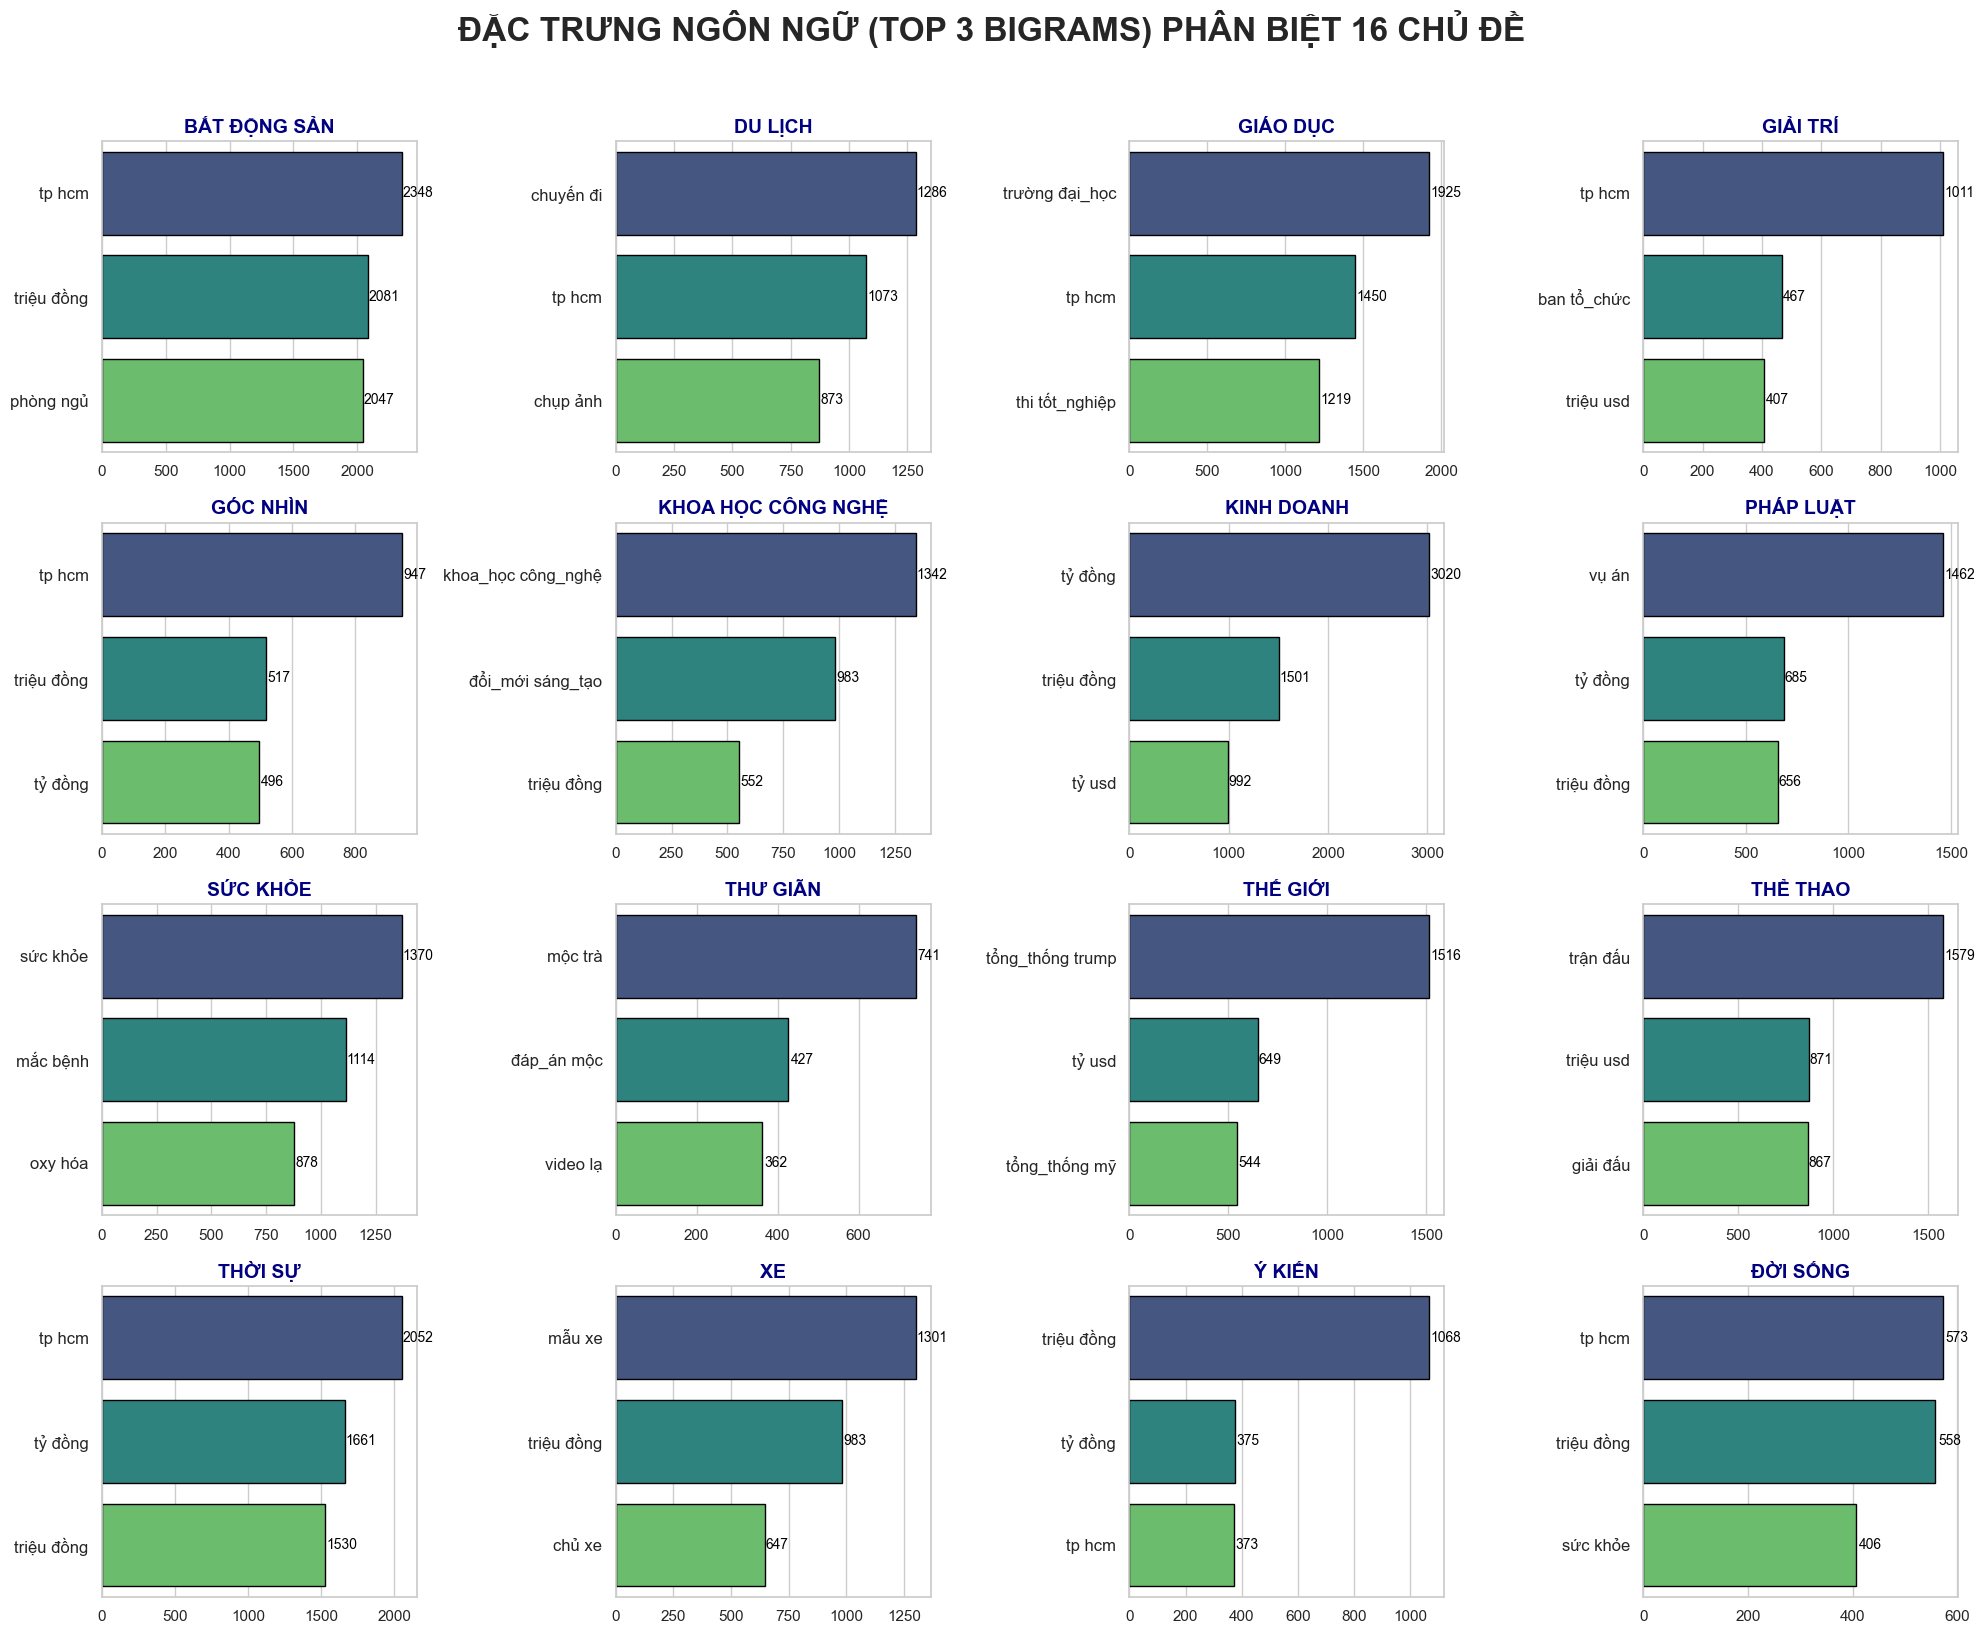

In [131]:
data_list = []
for category, bigrams in all_categories_top_ngrams.items():
    for word, freq in bigrams[:3]:
        data_list.append({'Category': category, 'Bigram': word, 'Frequency': freq})

df_ngrams = pd.DataFrame(data_list)
n_categories = len(df_ngrams['Category'].unique())
n_cols = 4
n_rows = math.ceil(n_categories / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16), sharex=False)
fig.suptitle('ĐẶC TRƯNG NGÔN NGỮ (TOP 3 BIGRAMS) PHÂN BIỆT 16 CHỦ ĐỀ', fontsize=24, y=1.02, weight='bold')
axes_flat = axes.flatten()
unique_categories = df_ngrams['Category'].unique()
for i, category in enumerate(unique_categories):
    ax = axes_flat[i]
    subset = df_ngrams[df_ngrams['Category'] == category]

    sns.barplot(
    data=subset, 
    x='Frequency', 
    y='Bigram', 
    ax=ax, 
    hue='Bigram',       
    palette='viridis',  
    dodge=False,        
    legend=False,      
    edgecolor='black'   
)
  
    ax.set_title(category.upper(), fontsize=14, weight='bold', color='navy')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=12) 
    for index, value in enumerate(subset['Frequency']):
        ax.text(value + 5, index, f'{value}', va='center', fontsize=10, color='black')

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

- Mình chỉ lựa chọn top 3 bigrams của từng chủ đề để trực quan phân tích (mỗi chủ đề có rất nhiều bigrams)

"Biểu đồ 'Đặc trưng ngôn ngữ phân biệt 16 chủ đề' (Hình X) minh họa 3 cụm từ ghép (Bigrams) xuất hiện với tần suất cao nhất trong từng nhóm tin tức. Có thể thấy một sự phân tách rõ rệt về ngữ nghĩa (Semantic Separation) giữa các nhóm Ví dụ:

-  Nhóm Bất động sản được định hình bởi các từ khóa tài chính chuyên biệt như 'tphcm', 'triệu đồng', 'phòng ngủ'.

- Ngược lại, Với nhóm pháp luật hoàn toàn khác biệt với các thuật ngữ mang tính chế tài như 'vụ án', 'tỷ đồng', 'triệu đồng'.

- Nhóm Sức khỏe tách biệt hoàn toàn nhờ các từ khóa y tế như 'sức khoẻ', 'mắc bệnh', 'oxy hoá'.

- Các từ định nghĩa rõ nhất cho từng lĩnh vực chủ đề đều có xu hướng tần suất xuất hiện nhiều.Sự khác biệt này là cơ sở vững chắc để mô hình Classification học các đặc trưng (Features) và đảm bảo độ chính xác cao.

### **Phân tích Tín hiệu Trending**

In [132]:
df_clean['date_time'] = pd.to_datetime(df_clean['date_clean'], errors='coerce', utc=True)
df_clean['date_only'] = df_clean['date_time'].dt.date

def plot_trending_signal(keyword, column='clean_content'):
    
    keyword_processed = keyword.lower().replace(" ", "_")
    
    mask = df_clean[column].str.contains(r'\b' + re.escape(keyword_processed) + r'\b', na=False)
    trend_data = df_clean[mask]
    
    trend_counts = trend_data.groupby('date_only').size().rename('Tần suất')
    
    all_dates = pd.date_range(start=df_clean['date_only'].min(), end=df_clean['date_only'].max(), freq='D')
    trend_counts = trend_counts.reindex(all_dates, fill_value=0)
    
    plt.figure(figsize=(15, 6))
    trend_counts.plot(kind='line', marker='.', linestyle='-', color='purple')
    plt.title(f'Tín hiệu Xu hướng của từ khóa "{keyword}"', fontsize=16)
    plt.ylabel('Số lần xuất hiện/Ngày')
    plt.xlabel('Thời gian')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


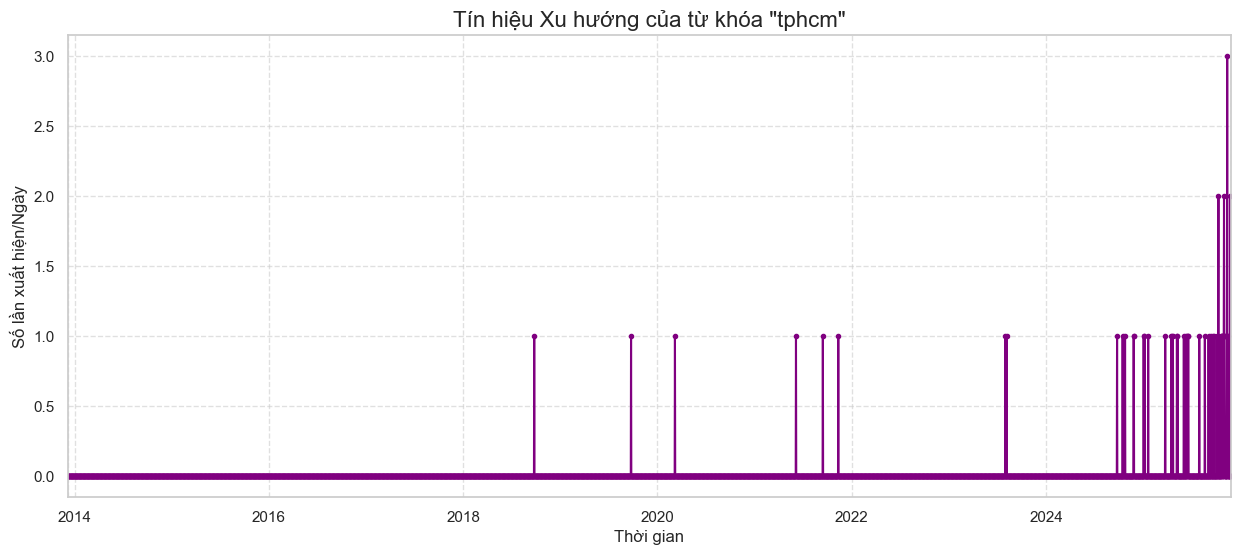

In [133]:
plot_trending_signal("tphcm")

- Biểu đồ cho thấy từ tphcm đề cập nhiều ở các bài báo ở giai đoạn năm 2024 đến 2025

### **Phân tích Sự kiện Chéo (Cross-Category Trend)**

<Figure size 1500x700 with 0 Axes>

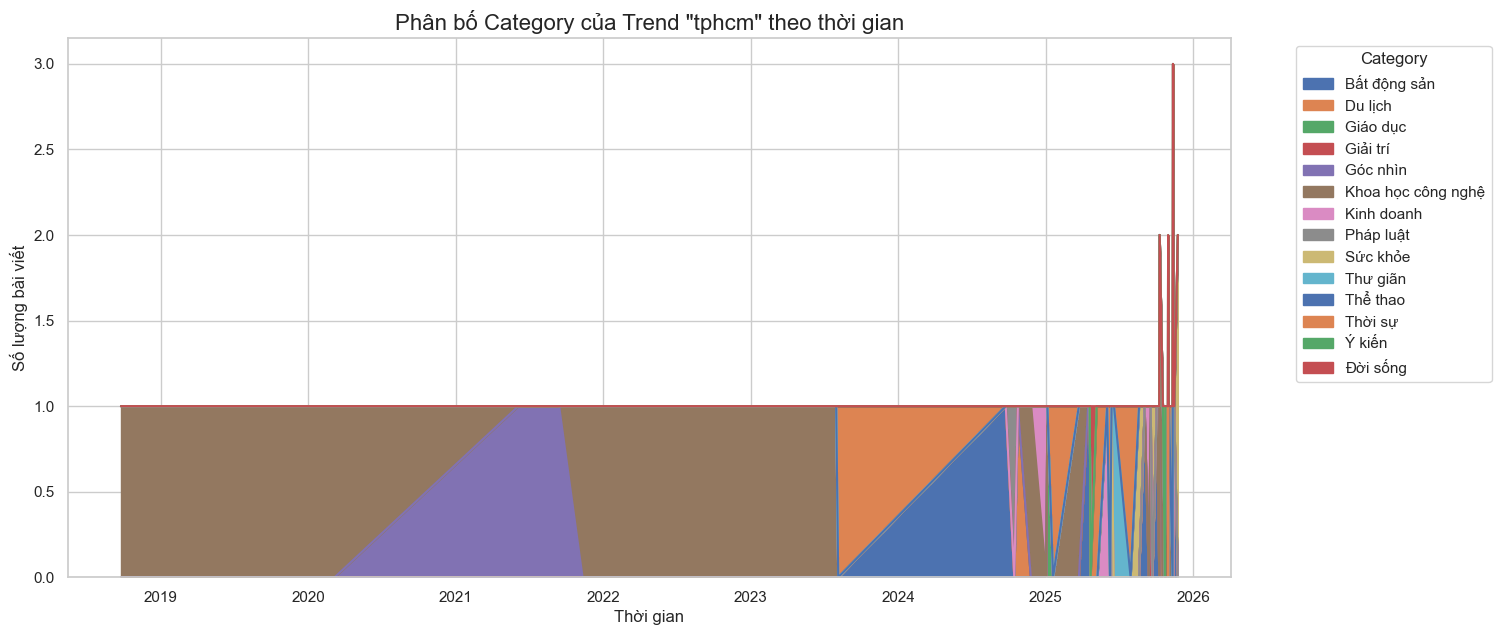

In [134]:

keyword_processed = "tphcm"
mask = df_clean['clean_content'].str.contains(r'\b' + re.escape(keyword_processed) + r'\b', na=False)
trend_category_data = df_clean[mask].copy()

category_trend_counts = trend_category_data.groupby(['date_only', 'category']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 7))
category_trend_counts.plot(kind='area', stacked=True, figsize=(15, 7))
plt.title(f'Phân bố Category của Trend "{keyword_processed.replace("_", " ")}" theo thời gian', fontsize=16)
plt.ylabel('Số lượng bài viết')
plt.xlabel('Thời gian')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- Biểu đồ Cross-Category Trend cho thấy từ tphcm ban đầu là tín hiệu mạnh mẽ nhất trong Khoa học công nghệ ở những năm trước và sau 2019 đến giữa nằm 2023, nhưng sau đó lan rộng sang Thời sự và thể thao (do các vụ kiện bóng đã nước nhà). Hơn giữa năm 2024 thì lan mạnh sang mọi lĩnh vực. Điều này chứng minh thuật toán Trending của chúng tôi không chỉ phát hiện sự kiện mà còn theo dõi được sự lan tỏa chủ đề trong các lĩnh vực khác nhau.

### **Word Cloud**

Đang tạo Word Clouds...


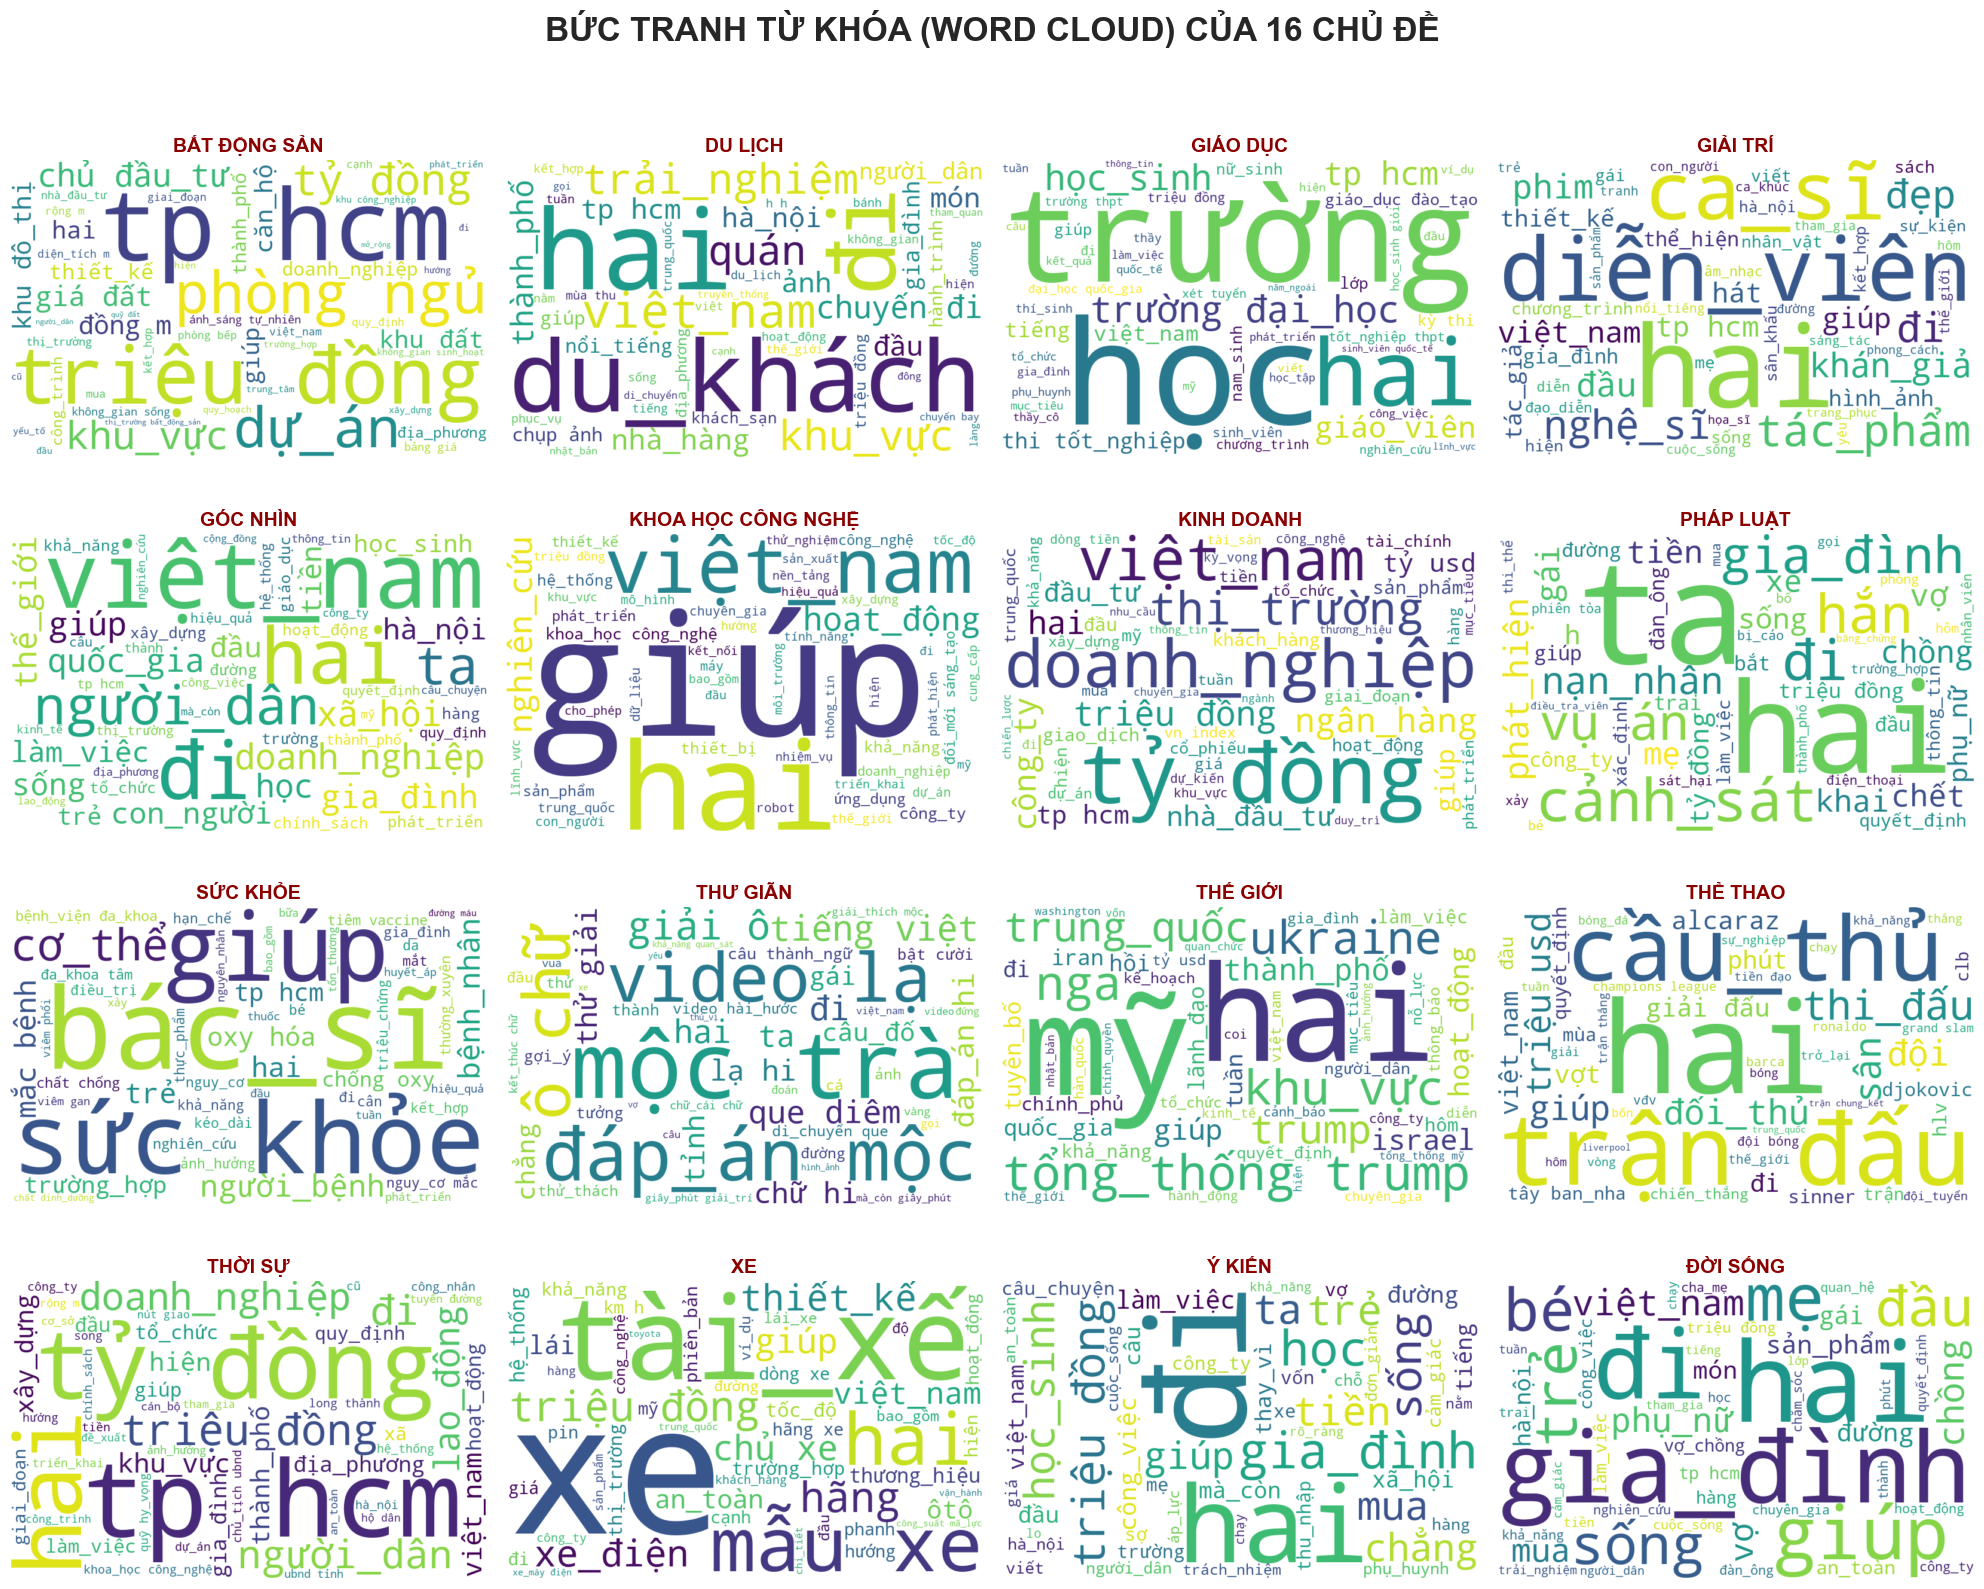

In [135]:
n_categories = len(all_categories)
n_cols = 4
n_rows = math.ceil(n_categories / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
fig.suptitle('BỨC TRANH TỪ KHÓA (WORD CLOUD) CỦA 16 CHỦ ĐỀ', fontsize=24, y=1.02, weight='bold')
axes_flat = axes.flatten()

print("Đang tạo Word Clouds...")
for i, category in enumerate(all_categories):
    ax = axes_flat[i]
    
    text_category = df_filtered[df_filtered['category'] == category]['clean_content']
    text_combined = " ".join(text_category.astype(str))
    
    wc = WordCloud(
        background_color='white', 
        max_words=50,             
        width=800, height=500,
        colormap='viridis'           
    ).generate(text_combined)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(category.upper(), fontsize=14, weight='bold', color='darkred')
    ax.axis('off') 

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

- Nếu biểu đồ cột cho chúng ta con số chính xác, thì Word Cloud cung cấp cảm nhận ngữ cảnh (Contextual Feeling). Nhìn vào Word Cloud của 'Giải trí', ta thấy ngay các từ 'diễn_viên', 'ca_sĩ' nổi bật, tạo ra sắc thái hoàn toàn khác với Word Cloud khác.